## Quadratic equation conditional workflow

In [3]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict , Literal


In [4]:
class QuadState(TypedDict):
    a: int
    b: int
    c: int

    equation: str
    discriminant: float
    result: str

In [5]:
def show_equation(state: QuadState):
    equation = f"{state['a']}x2+({state['b']})x+({state['c']})"

    return {'equation':equation}

def calculate_d(state: QuadState):
    d = (state['b']**2 - (4*state['a']*state['c']))

    return {'discriminant':d}


def real_roots(state: QuadState):
    root1 = (-state['b']+ state['discriminant']**0.5)/(2*state['a'])
    root2 = (-state['b']- state['discriminant']**0.5)/(2*state['a'])

    result =  f"The real roots are {root1} and {root2}"

    return {'result':result}

def repeated_roots(state: QuadState):
    root1 = -state['b']/(2*state['a'])

    result =  f"The only repeating root is {root1}"

    return {'result':result}

def no_real_roots(state: QuadState):
    result =  "NO real roots"

    return {'result':result}


def check_condition(state: QuadState) -> Literal['real_roots' , 'no_real_roots' , 'repeated_roots']:
    if state['discriminant']>0:
        return 'real_roots'
    
    elif state['discriminant']==0:
        return 'repeated_roots'
    
    else:
        return "no_real_roots"

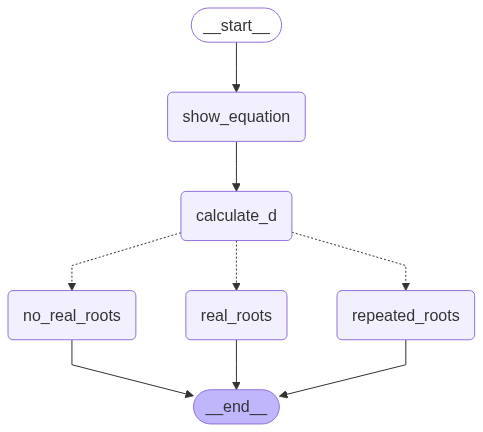

In [7]:
graph = StateGraph(QuadState)
graph.add_node('show_equation' , show_equation)
graph.add_node('calculate_d' , calculate_d)
graph.add_node('real_roots' , real_roots)
graph.add_node('repeated_roots' , repeated_roots)
graph.add_node('no_real_roots' , no_real_roots)



graph.add_edge(START , "show_equation")
graph.add_edge('show_equation' , 'calculate_d')
graph.add_conditional_edges('calculate_d' , check_condition)
graph.add_edge('calculate_d' , END)
graph.compile()

In [8]:
initial_state = {
    'a':4,
    'b':-3,
    'c':-9
}
app = graph.compile()
app.invoke(initial_state)

{'a': 4,
 'b': -3,
 'c': -9,
 'equation': '4x2+(-3)x+(-9)',
 'discriminant': 153,
 'result': 'The real roots are 1.9211646096066226 and -1.1711646096066226'}

## LLM Based Parallel Workflow

In [1]:
from langgraph.graph import StateGraph ,START , END
from typing import TypedDict , Annotated
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from pydantic import BaseModel , Field
import operator
import os
load_dotenv()
GROQ_API_KEY = os.getenv('GROQ_API_KEY1')

model = ChatGroq(model_name="llama3-70b-8192", api_key=GROQ_API_KEY, temperature=0.7)


In [4]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive' , 'negative'] = Field(description='Sentiment of the review')


structured_model = model.with_structured_output(SentimentSchema)

In [10]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal['UX' , 'Performance' , 'Bug' , 'Support' , 'Other'] = Field(description='the category of issue mentioned in the review')
    tone: Literal['frustrated', 'angry', 'disapointed' , 'calm'] = Field(description='The emotional tone expressed by the user')
    urgency: Literal['low' , 'medium' , 'high'] = Field(description='How urgent or critical the issue appears to be')

structured_model2 = model.with_structured_output(DiagnosisSchema)


In [5]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive' , 'negative']
    diagnosis: dict
    response: str

In [7]:
def find_sentiment(state: ReviewState):
    prompt = f"For the following review find out the sentiment \n {state['review']}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {'sentiment': sentiment}


def check_sentiment(state: ReviewState) -> Literal["positive_response",'run_diagnosis']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: ReviewState):
    prompt = f"""
                Write a warm thank-you message in response to this review: 
                \n\n "{state['review']}\"\n
                Also, kindly ask the user to leave feedback on our website"""
    response = model.invoke(prompt).content

    return {'response' : response}
    
def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnosis this negative review: \n\n '{state['review']}'\n
    Return issue_type , tone and urgency"""
    response = structured_model2.invoke(prompt)
    return {'diagnosis': response.model_dump()}

def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistance
                The user had a '{diagnosis['issue_type']}' issue , sounded '{diagnosis['tone']}' , and marked urgency as '{diagnosis['urgency']}'
                Write an empathetic, helpful resolution message"""
    response = model.invoke(prompt).content

    return {'response' : response}


In [8]:
graph = StateGraph(ReviewState)
graph.add_node('find_sentiment' , find_sentiment)
graph.add_node('positive_response' , positive_response)
graph.add_node('negative_response' , negative_response)
graph.add_node('run_diagnosis' , run_diagnosis)

graph.add_edge(START , 'find_sentiment')
graph.add_conditional_edges('find_sentiment' , check_sentiment)
graph.add_edge('positive_response' , END)
graph.add_edge('run_diagnosis' ,'negative_response')
graph.add_edge('negative_response' , END)

app = graph.compile()


In [11]:
initial_state ={
    'review': 'Performance is not up to the mark , hangs a lot... I need my phone repaired urgently...'
}

app.invoke(initial_state)

{'review': 'Performance is not up to the mark , hangs a lot... I need my phone repaired urgently...',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Performance',
  'tone': 'frustrated',
  'urgency': 'high'},
 'response': "**Urgent: Performance Issue Resolution**\n\nDear [User's Name],\n\nI'm so sorry to hear that you're experiencing performance issues, and I can sense your frustration. I'm here to help you resolve this issue as quickly as possible. I understand how crucial it is to have a seamless experience, and I apologize for any inconvenience this has caused.\n\nI've escalated your issue to our top priority, and I'll work closely with our technical team to get to the bottom of this. To better assist you, could you please provide more details about the performance issues you're facing? For example:\n\n* What specific actions were you performing when the issue occurred?\n* Are there any error messages or screenshots you can share with me?\n* Have you noticed any patterns or